# Poisson regresson

Using pymc3

* https://docs.pymc.io/en/stable/pymc-examples/examples/generalized_linear_models/GLM-poisson-regression.html
* https://docs.pymc.io/en/stable/pymc-examples/examples/generalized_linear_models/GLM-linear.html
* https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-logistic.html
* https://github.com/bambinos/bambi

## Setup libraries

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import pandas as pd
import scipy.stats as st

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
import patsy

In [3]:
from numpy.random import default_rng
rng = default_rng()

In [4]:
warnings.simplefilter(action="ignore",
                      category=(FutureWarning, DeprecationWarning))

## Plotting specifications

In [5]:
az.style.use("arviz-darkgrid")
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams["figure.dpi"] = 50
palette = sns.color_palette()

## Create data

In [6]:
# decide poisson theta values
theta_noalcohol_meds = 1  # no alcohol, took an antihist
theta_alcohol_meds = 3  # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36  # alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            (
                rng.poisson(theta_noalcohol_meds, q),
                rng.poisson(theta_alcohol_meds, q),
                rng.poisson(theta_noalcohol_nomeds, q),
                rng.poisson(theta_alcohol_nomeds, q),
            )
        ),
        "alcohol": np.concatenate(
            (
                np.repeat(False, q),
                np.repeat(True, q),
                np.repeat(False, q),
                np.repeat(True, q),
            )
        ),
        "nomeds": np.concatenate(
            (
                np.repeat(False, q),
                np.repeat(False, q),
                np.repeat(True, q),
                np.repeat(True, q),
            )
        ),
    }
)

In [7]:
df.head()

,nsneeze,alcohol,nomeds
0,1,False,False
1,0,False,False
2,2,False,False
3,2,False,False
4,0,False,False


## Summarize data

In [8]:
df.groupby(["alcohol", "nomeds"]).mean().unstack()

nsneeze        
nomeds    False   True 
alcohol                
False     0.991   5.939
True      2.983  35.781

## Plot data

/home/gavin/.cache/pypoetry/virtualenvs/scikit-vm-U5TtebPB-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


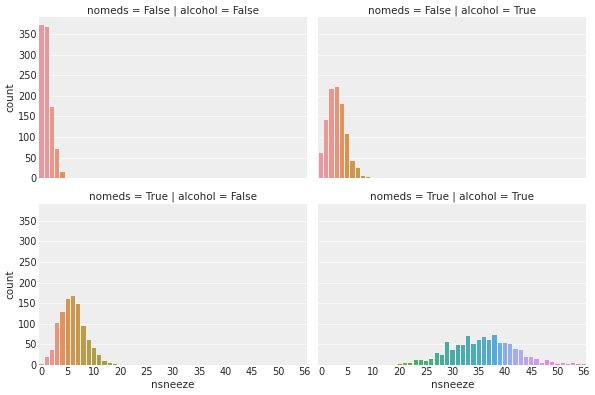

In [9]:
g = sns.catplot(
    x="nsneeze",
    row="nomeds",
    col="alcohol",
    data=df,
    kind="count",
    height=4,
    aspect=1.5,
)
for ax in g.axes.flatten()[-2:]:
    for idx, label in enumerate(ax.xaxis.get_ticklabels()):
        label.set_visible(idx % 5 == 0)  # show every 5th label

## Create dmatrices

In [10]:
df.columns

Index(['nsneeze', 'alcohol', 'nomeds'], dtype='object')

In [11]:
fml = "nsneeze ~ alcohol + nomeds + alcohol:nomeds"

In [12]:
outcome_dm, predictors_dm = patsy.dmatrices(fml, df)

In [13]:
outcome = outcome_dm.squeeze()

In [14]:
pdt = pd.DataFrame.from_records(
    predictors_dm[:, :], columns=predictors_dm.design_info.column_names)

In [15]:
pdt.columns

Index(['Intercept', 'alcohol[T.True]', 'nomeds[T.True]',
       'alcohol[T.True]:nomeds[T.True]'],
      dtype='object')

## Setup model

In [16]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=10)
    b1 = pm.Normal("alcohol", mu=0, sigma=10)
    b2 = pm.Normal("nomeds", mu=0, sigma=10)
    b3 = pm.Normal("alcohol:nomeds", mu=0, sigma=10)

    # define linear model and exp link function
    theta = (b0 + b1 * pdt.values[:, 1] + b2 * pdt.values[:, 2] + 
             b3 * pdt.values[:, 3])

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=np.exp(theta), observed=df["nsneeze"])

## Run inference

In [17]:
with pm.Model() as model2:  # automatically uses log link function for Poisson
    pm.glm.GLM.from_formula(
        "nsneeze ~ alcohol + nomeds + alcohol:nomeds", df, family=pm.glm.families.Poisson()
    )

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [18]:
with model:
    trace = pm.sample(2000, tune=2000, cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alcohol:nomeds, nomeds, alcohol, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.697406882473661, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'alcohol'}>],
       [<AxesSubplot:title={'center':'nomeds'}>,
        <AxesSubplot:title={'center':'nomeds'}>],
       [<AxesSubplot:title={'center':'alcohol:nomeds'}>,
        <AxesSubplot:title={'center':'alcohol:nomeds'}>]], dtype=object)

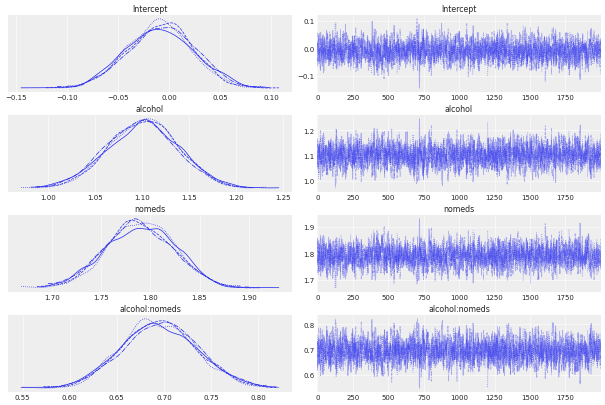

In [19]:
az.plot_trace(trace)

## Display results

In [20]:
trace_result = az.summary(trace.posterior)
trace_result

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.009,0.032,-0.071,0.049,0.001,0.001,1478.0,1851.0,1.0
alcohol,1.101,0.037,1.034,1.172,0.001,0.001,1524.0,2109.0,1.0
nomeds,1.790,0.035,1.725,1.855,0.001,0.001,1470.0,2012.0,1.0
alcohol:nomeds,0.695,0.040,0.624,0.772,0.001,0.001,1486.0,2050.0,1.0


Compare with theta values

In [21]:
np.exp(trace_result['mean'])

Intercept         0.991040
alcohol           3.007172
nomeds            5.989452
alcohol:nomeds    2.003709
Name: mean, dtype: float64